In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
# Check if a GPU is available
if torch.cuda.is_available():
    # Get the current device index (default is 0 if no other device is specified)
    current_device = torch.cuda.current_device()
    
    # Get the name of the GPU at this device index
    gpu_name = torch.cuda.get_device_name(current_device)
    print(f"Current GPU: {gpu_name}")
else:
    print("No GPU available.")


Current GPU: NVIDIA GeForce RTX 3080


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import bitsandbytes 
compute_dtype = getattr(torch, "float16")



# Load the base model and tokenizer
model_id = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_id,load_in_8bit=True, device_map="auto") # Must be float32 for MacBooks!
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [3]:
# Load the training dataset
dataset = load_dataset("vishnun0027/Indian-Law")
dataset = dataset["train"]
dataset = dataset.filter(lambda x: x["Instruction"] is not None and x["Response"] is not None)
dataset

Dataset({
    features: ['Instruction', 'Response'],
    num_rows: 25600
})

In [4]:
def visualize_token_lengths(dataset, text_column="text"):
    # Load tokenizer
    
    # Tokenize and get lengths
    token_lengths = []
    for entry in dataset:
        # print(entry)
        tokens = tokenizer(entry[text_column], truncation=True, padding=False)
        token_lengths.append(len(tokens["input_ids"]))
    
    # Plot histogram of token lengths
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=10, color="skyblue", edgecolor="black")
    plt.title("Token Length Distribution")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.show()

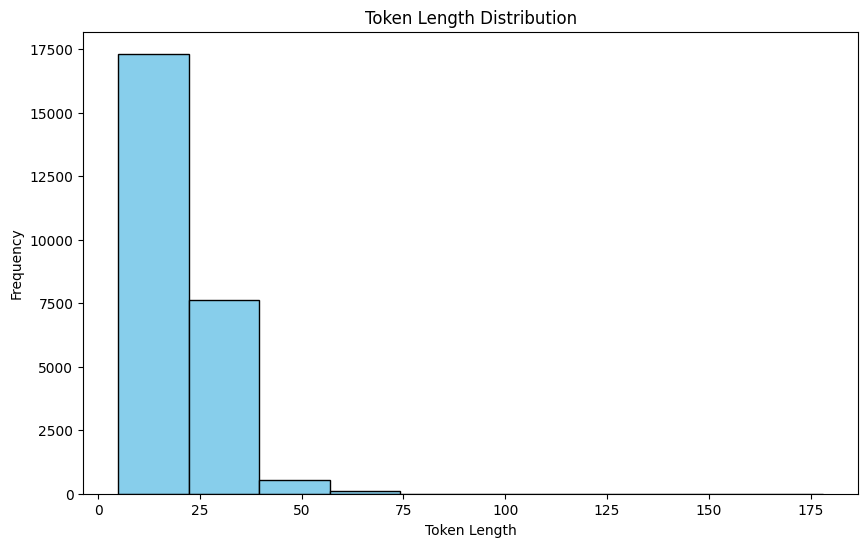

In [5]:
# Visualize token lengths
visualize_token_lengths(dataset, text_column="Instruction")

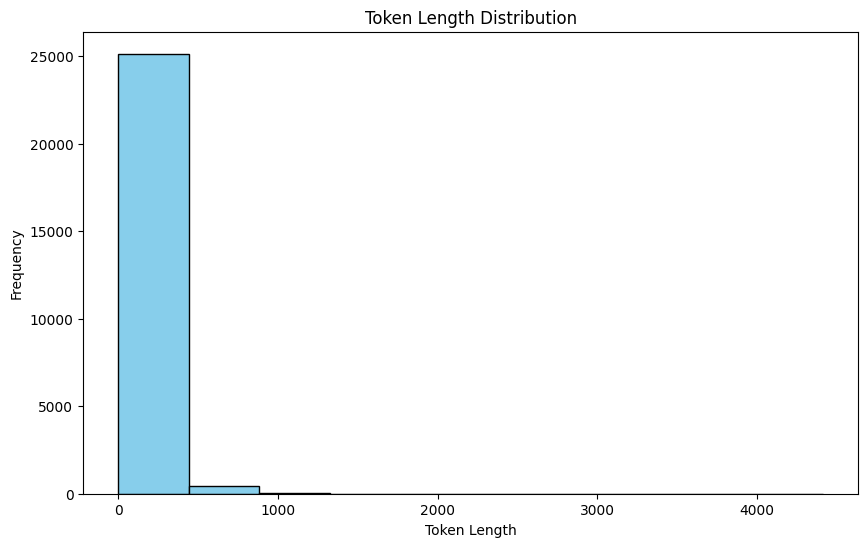

Percentiles of token lengths:
50th: 72.0
75th: 102.0
90th: 163.0
95th: 329.0
99th: 531.0
Suggested max_length (90th percentile): 163.0


In [6]:
def determine_optimal_max_length(dataset, text_column="text"):
    # Initialize tokenizer
    
    # Tokenize dataset and store token lengths
    token_lengths = [len(tokenizer(entry[text_column], truncation=False)["input_ids"]) for entry in dataset]
    
    # Plot token length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=10, color="skyblue", edgecolor="black")
    plt.title("Token Length Distribution")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.show()
    
    # Calculate percentiles for token lengths
    percentiles = np.percentile(token_lengths, [50, 75, 90, 95, 99])
    print(f"Percentiles of token lengths:\n50th: {percentiles[0]}\n75th: {percentiles[1]}\n90th: {percentiles[2]}\n95th: {percentiles[3]}\n99th: {percentiles[4]}")
    
    # Suggest a max_length, e.g., 90th percentile to cover most cases
    suggested_max_length = percentiles[2]
    print(f"Suggested max_length (90th percentile): {suggested_max_length}")
    
    return suggested_max_length

# Determine optimal max_length based on token length distribution
suggested_max_length = determine_optimal_max_length(dataset,text_column="Response")

In [7]:
# Define a function to apply the chat template
def apply_chat_template(example):
    messages = [
        {"role": "user", "content": example['Instruction']},
        {"role": "assistant", "content": example['Response']}
    ]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return {"prompt": prompt}

In [8]:
# Apply the chat templatefunction to the dataset
new_dataset = dataset.map(apply_chat_template)
new_dataset = new_dataset.train_test_split(0.05) # Let's keep 5% of the data for testing

In [9]:
new_dataset['train'][0]['prompt']

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 04 Nov 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWhat is the role of Parliament under clause (2) in relation to the President's authority?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nUnder clause (2), the role of Parliament is to make provision for rules regulating the recruitment and conditions of service of persons appointed to the secretarial staff of the House of the People or the Council of States. Until Parliament takes this action, the President may make such rules after consultation with the Speaker of the House of the People or the Chairman of the Council of States, as applicable. Any rules made by the President shall have effect subject to the provisions of any law made under the said clause.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

In [10]:
# Tokenize the data
def tokenize_function(example):
    # Tokenize the 'prompt' text in each example, ensuring consistent sequence length
    # padding="max_length" pads all sequences to the max length specified (128 tokens)
    # truncation=True cuts off any tokens that exceed this max length
    tokens = tokenizer(example['prompt'], padding="max_length", truncation=True, max_length=128)
    
    # Create 'labels' key to store token labels for training
    # Set padding token labels to -100 to ignore them during the loss calculation
    # The -100 label is a special value in PyTorch, meaning "ignore this position in loss computation"
    tokens['labels'] = [
        -100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']
    ]
    
    # Return the tokenized dictionary, now with 'input_ids' and 'labels' keys
    return tokens

In [11]:
# Apply tokenize_function to each row
tokenized_dataset = new_dataset.map(tokenize_function)
tokenized_dataset = tokenized_dataset.remove_columns(['Instruction', 'Response', 'prompt'])

Map:   0%|          | 0/24320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [12]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 24320
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1280
    })
})

In [13]:
tokenized_dataset['train'][0]['input_ids'][:10]

[128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696]

In [14]:
tokenized_dataset['train'][0]['attention_mask'][:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [15]:
tokenized_dataset['train'][0]['labels'][:10]

[128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696]

In [16]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)
model.add_adapter(peft_config)


In [17]:
model.train()
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate at the end of each epoch to reduce interruptions
    logging_steps=500,  # Log less frequently to improve speed
    save_steps=500,  # Save less frequently to avoid disk usage issues
    per_device_train_batch_size=8,  # Higher batch size, assuming GPU or hardware capacity allows
    per_device_eval_batch_size=8,  # Matches training batch size
    num_train_epochs=3,  # A bit more coverage with larger dataset
    fp16=False,  # Keep False if using MacBook or no GPU support
    report_to="none",
    log_level="info",
    learning_rate=2e-5,  # Slightly higher learning rate for faster convergence
    max_grad_norm=1.0,  # More conservative gradient clipping for stability
)


In [18]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer)

/tmp/ipykernel_3584/2935008737.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
# Train the model
trainer.train()

***** Running training *****
  Num examples = 24,320
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9,120
  Number of trainable parameters = 6,815,744


Epoch,Training Loss,Validation Loss
1,1.406600,1.396925
2,1.368100,1.368543
3,1.359800,1.360918


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/generation_config.json
Detected adapters on the model, saving the model in the PEFT format, only adapter weights will be saved.
/home/home/dev/venv/lib/python3.11/site-packages/transformers/integrations/peft.py:418: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
loading configuration file config.json from cache at /home/home/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,


TrainOutput(global_step=9120, training_loss=1.406967484323602, metrics={'train_runtime': 2369.3193, 'train_samples_per_second': 30.794, 'train_steps_per_second': 3.849, 'total_flos': 5.519947957744435e+16, 'train_loss': 1.406967484323602, 'epoch': 3.0})

In [21]:
# Save the model and tokenizer
trainer.save_model("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

Saving model checkpoint to ./fine-tuned-model
Configuration saved in ./fine-tuned-model/generation_config.json
Detected adapters on the model, saving the model in the PEFT format, only adapter weights will be saved.
/home/home/dev/venv/lib/python3.11/site-packages/transformers/integrations/peft.py:418: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
loading configuration file config.json from cache at /home/home/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias"

('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/tokenizer.json')